salp_navigate_8a/mlp: 5 trials
salp_navigate_8a/gcn: 5 trials
salp_navigate_8a/gat: 5 trials
salp_navigate_8a/graph_transformer: 5 trials
salp_navigate_8a/gcn_full: 5 trials
salp_navigate_8a/gat_full: 5 trials
salp_navigate_8a/graph_transformer_full: 5 trials
salp_navigate_16a/mlp: 5 trials
salp_navigate_16a/gcn: 5 trials
salp_navigate_16a/gat: 5 trials
salp_navigate_16a/graph_transformer: 5 trials


/tmp/ipykernel_13853/4231323057.py:93: RuntimeWarning: Mean of empty slice
  mean_rewards = np.nanmean(data_array, axis=0)
/home/magraz/research/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


salp_navigate_16a/gcn_full: 5 trials
salp_navigate_16a/gat_full: 5 trials
salp_navigate_16a/graph_transformer_full: 5 trials


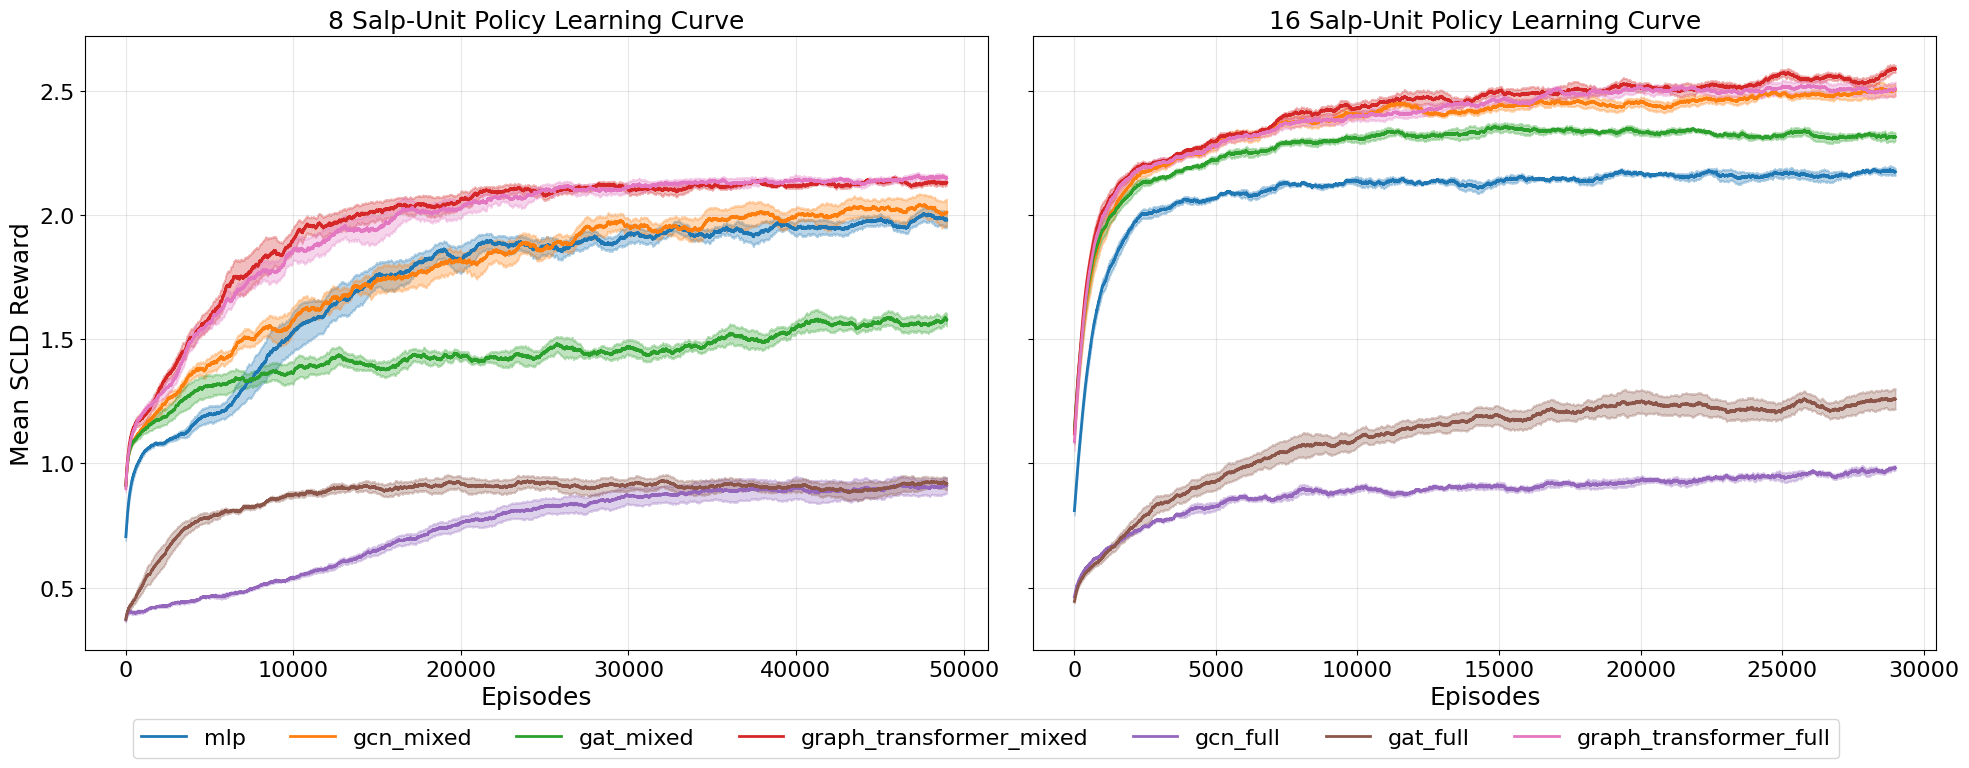

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import numpy as np
import pickle
import yaml

plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)  # sharey=True makes y-axis scale the same

# Store data by batch and experiment
batch_data = {}
for batch in config["batches"]:
    batch_data[batch] = defaultdict(list)

max_len = 0

# First pass: collect data for each experiment grouped by batch
for i, batch in enumerate(config["batches"]):
    datapoints = config["datapoints"][i]
    for experiment in config["experiments"]:
        for trial in config["trials"]:
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/train.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)["rewards_per_episode"][:datapoints]
                    
                    # Apply moving average
                    if len(data) > config["moving_avg_window_size"]:
                        smoothed_data = moving_average(data, config["moving_avg_window_size"])
                        batch_data[batch][experiment].append(smoothed_data)
                        max_len = max(max_len, len(smoothed_data))
                    else:
                        print(f"Warning: {batch}/{experiment}/{trial} has too few data points for smoothing")

# Second pass: pad arrays to the same length if needed
for batch in batch_data:
    for exp in batch_data[batch]:
        padded_data = []
        for trial_data in batch_data[batch][exp]:
            if len(trial_data) < max_len:
                # Pad with NaN
                padding = np.full(max_len - len(trial_data), np.nan)
                padded_data.append(np.concatenate([trial_data, padding]))
            else:
                padded_data.append(trial_data)
        
        batch_data[batch][exp] = padded_data

# Store line objects and labels for combined legend
all_lines = []
all_labels = ["mlp", "gcn_mixed", "gat_mixed", "graph_transformer_mixed", "gcn_full", "gat_full", "graph_transformer_full"]

titles = ["8 Salp-Unit Policy Learning Curve", "16 Salp-Unit Policy Learning Curve"]

# Plot each batch in its respective subplot
for batch_idx, batch in enumerate(config["batches"]):
    ax = axes[batch_idx]
    color_idx = 0

    
    # Add batch name as subplot title
    ax.set_title(f"{titles[batch_idx]}")
    
    for exp in batch_data[batch]:
        if not batch_data[batch][exp]:
            print(f"No data for {batch}/{exp}")
            continue
            
        # Convert list of arrays to 2D numpy array
        data_array = np.array(batch_data[batch][exp])
        
        # Calculate mean and standard error across trials
        mean_rewards = np.nanmean(data_array, axis=0)
        
        # Standard Error = StdDev / sqrt(n)
        n_trials = np.sum(~np.isnan(data_array), axis=0)  # Count non-NaN values at each step
        std_rewards = np.nanstd(data_array, axis=0)
        se_rewards = std_rewards / np.sqrt(np.maximum(n_trials, 1))  # Avoid division by zero
        
        # X axis
        x = np.arange(len(mean_rewards))
        
        # Get color for this experiment
        color = plt.cm.tab10(color_idx % 10)
        color_idx += 1
        
        # Plot mean line
        line = ax.plot(x, mean_rewards, linewidth=2, label=exp, color=color)

        # Store line and label for combined legend
        # Only add to legend from first subplot to avoid duplicates
        if batch_idx == 0:
            all_lines.append(line[0])
        
        # Plot standard error band
        ax.fill_between(
            x,
            mean_rewards - se_rewards,
            mean_rewards + se_rewards,
            alpha=0.3,
            color=color
        )
        
        print(f"{batch}/{exp}: {len(batch_data[batch][exp])} trials")

    # Add legend, labels, grid to each subplot
    # ax.legend(loc='upper left', fontsize=10)
    ax.set_xlabel("Episodes")
    
    # Only add y-label to the leftmost subplot
    if batch_idx == 0:
        ax.set_ylabel("Mean SCLD Reward")
        
    ax.grid(True, alpha=0.3)

# Create a single legend for the entire figure
fig.legend(all_lines, all_labels, 
           loc='lower center',  # Position below the subplots
           bbox_to_anchor=(0.5, -0.12),  # Center horizontally, below plots
           ncol=len(all_labels))

# Add more padding at the bottom for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)  # Make room for the legend below plots

plt.savefig("learning_curves_comparison.png", dpi=300, bbox_inches="tight")
plt.show()